In [1]:
%matplotlib widget

# Session 2.2

## Multi-material samples with ![gVXR](../img/gvxr_logo.png)

## Authors: Ben Thorpe, Iwan Mitchel and Franck Vidal

(version 1.0, 04 Oct 2022)

# Aims of this session

- Create X-ray simulations of samples involving multiple materials
    - Multiple individual materials (e.g. a Copper pipe inside an Aluminium block)
    - Metal Alloys and Mixtures
    - Chemical Compounds
- Visualise the effects of different materials on the resulting X-ray images

## Working With Multiple materials
In the previous notebook we had a single model made of a single material. The plan now is to work up to something a bit more interesting. A multi-part model using multiple different materials. The sample in question is a Turbo pump[^1]. This can be found as a 3D model consisting of series of stl files representing the different internal and external parts.

![Screenshot of Paraview](../img/Turbo_Pump.png)

[^1]: https://grabcad.com/library/turbo-pump-50/details?folder_id=8605076

## Import packages

To get started we will need to import the required packages. The next cell is the same boilerplate code used in the previous notebook to set everything up for the session. Once again we don't need to know the exact details at this stage so for now we can safely run this cell and move on. However, for the curious the comments explain what the various packages are for.  

In [2]:
import os
import numpy as np # Who does not use Numpy?
import matplotlib # To plot images
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table

font = {'family' : 'serif',
         'size'   : 10
       }
matplotlib.rc('font', **font)

# Uncomment the line below to use LaTeX fonts
# matplotlib.rc('text', usetex=True)

from tifffile import imread, imwrite # Write TIFF files

import base64 # Save the visualisation

from gvxrPython3 import gvxr # Simulate X-ray images
from gvxrPython3.utils import saveProjections # Plot the X-ray image in linear, log and power law scales
from gvxrPython3.utils import compareWithGroundTruth # Plot the ground truth, the test image, and the relative error map in %
from gvxrPython3.utils import interactPlotPowerLaw # Plot the X-ray image using a Power law look-up table
from gvxrPython3.utils import visualise # Visualise the 3D environment if k3D is supported
from gvxrPython3.utils import plotScreenshot # Visualise the 3D environment if Matplotlib is supported

## Create an OpenGL context

As with the previous notebook we will need to create an OpenGL context using `gvxr.createWindow(window_id, visible, backend, opengl_major_version, opengl_minor_version)`

For this tutorial (and the subsequent ones) we will stick with **"EGL"** for the backend, this is because we are using the Cloud for this training. On my PC and laptop, I would use "OPENGL" to enable an interactive 3D visualisation window. 

In [3]:
print("Create an OpenGL context")

window_id = 0
opengl_major_version = 4
opengl_minor_version = 5

# gvxr.createOpenGLContext(window_id, opengl_major_version, opengl_minor_version);

# backend = "OPENGL"
# visible = True

# gvxr.createWindow(window_id, visible, backend, opengl_major_version, opengl_minor_version);

visible = False
# gvxr.createWindow(window_id, visible, backend, opengl_major_version, opengl_minor_version);

backend = "EGL"
# visible has no effect with EGL
gvxr.createWindow(window_id, visible, backend, opengl_major_version, opengl_minor_version);

Create an OpenGL context


Wed Oct 12 08:28:31 2022 ---- Create window (ID: 0)
Wed Oct 12 08:28:31 2022 ---- Query the number of EGL devices
Wed Oct 12 08:28:31 2022 ---- Success
Wed Oct 12 08:28:31 2022 ---- Detected 2 EGL devices.
Wed Oct 12 08:28:31 2022 ---- Print the details here of every EGL device.
Wed Oct 12 08:28:31 2022 ---- Success
Wed Oct 12 08:28:31 2022 ---- Device 1/2:
Wed Oct 12 08:28:31 2022 ---- 	Device Extensions: EGL_NV_device_cuda EGL_EXT_device_drm EGL_EXT_device_drm_render_node EGL_EXT_device_query_name EGL_EXT_device_persistent_id
Wed Oct 12 08:28:31 2022 ---- 	Device vendor: NVIDIA
Wed Oct 12 08:28:31 2022 ---- 	Failed to retrieve EGL DRM device file.
Wed Oct 12 08:28:31 2022 ---- Device 2/2:
Wed Oct 12 08:28:31 2022 ---- 	Device Extensions: EGL_MESA_device_software
Wed Oct 12 08:28:31 2022 ---- 	Failed to retrieve device vendor.
Wed Oct 12 08:28:31 2022 ---- 	Failed to retrieve EGL DRM device file.
Wed Oct 12 08:28:31 2022 ---- EGL client extensions: EGL_EXT_platform_base EGL_EXT_device

## Setting up the Scene

Now that we have our OpenGL context we need to import the different pieces of the model and set the parameters for the source, detector ect.

---
## Task

Using knowledge from, the previous notebook setup the scene as follows:
- place a 300 KeV monochromatic X-Ray source of 1000 photons at `x = 0`, `y = -40.0 cm`, `z = 0.0 cm`
- place the X-Detector at `x = 0`, `y = 30.0 cm`, `z = 0.0 cm`
- set the Detector to have 800 pixels in x and y spaced 0.7 mm apart in both directions. Also set the upVector to be along the negative z-axis i.e. (0.0,0.0,-1.0)
- Import the 6 stl files, found in `input_data/TurboPump` each with appropriate unique id.
- place the centre of the bounding box of the pump at `x = 0`, `y = 20.0 cm`, `z = 0.0 cm`

Wed Oct 12 08:28:31 2022 ---- Initialise the renderer
Wed Oct 12 08:28:31 2022 ---- file_name:	../input_data/TurboPump/internals.stl	nb_faces:	87620	nb_vertices:	262860	bounding_box (in cm):	(-3.48613, -5.55, -3.48613)	(3.48613, -0.735, 3.48613)
Wed Oct 12 08:28:31 2022 ---- file_name:	../input_data/TurboPump/coupler.stl	nb_faces:	2532	nb_vertices:	7596	bounding_box (in cm):	(-4.13387, -11.365, -4.13387)	(4.13387, -5.55, 4.13387)
Wed Oct 12 08:28:31 2022 ---- file_name:	../input_data/TurboPump/front_flange.stl	nb_faces:	6120	nb_vertices:	18360	bounding_box (in cm):	(-11.425, 0, -11.425)	(11.425, 3.535, 11.425)
Wed Oct 12 08:28:31 2022 ---- file_name:	../input_data/TurboPump/rear_flange.stl	nb_faces:	10516	nb_vertices:	31548	bounding_box (in cm):	(-11.425, -15.535, -11.425)	(11.425, -6.73, 11.425)
Wed Oct 12 08:28:31 2022 ---- file_name:	../input_data/TurboPump/housing.stl	nb_faces:	33368	nb_vertices:	100104	bounding_box (in cm):	(-12.3086, -8.5025, -14.9408)	(16.5171, 1.8975, 14.8965)


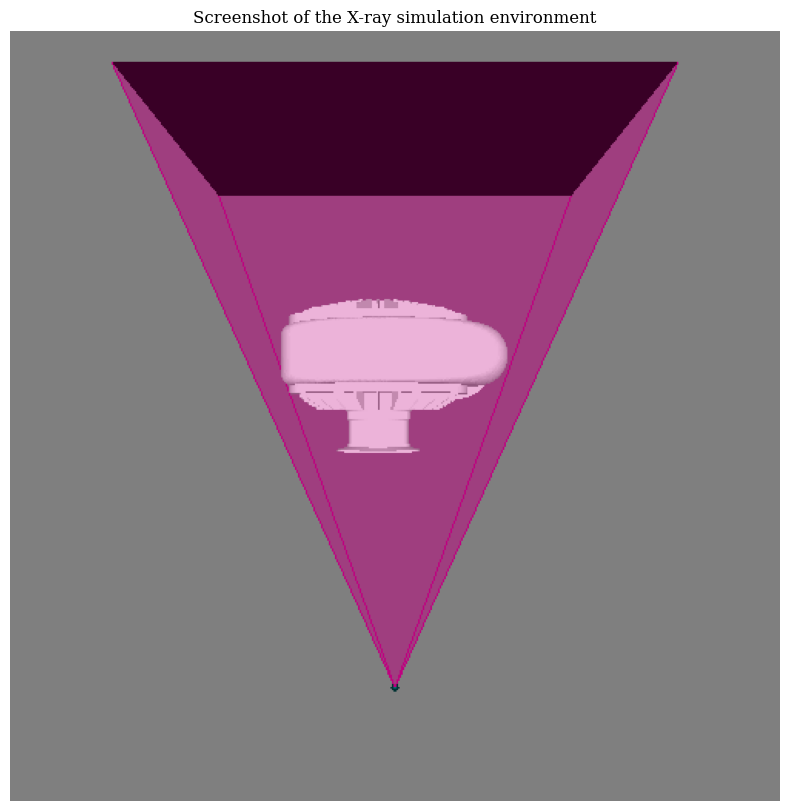

In [4]:
gvxr.setSourcePosition(0.0, -40.0, 0.0, "cm")
gvxr.usePointSource()
gvxr.setMonoChromatic(0.3, "MeV", 1000)
gvxr.setDetectorNumberOfPixels(800, 800)
gvxr.setDetectorPixelSize(0.7, 0.7, "mm")
gvxr.setDetectorPosition(0.0, 30.0, 0.0, "cm")
gvxr.setDetectorUpVector(0, 0, -1)

parts_list = ["internals","coupler","front_flange","rear_flange","housing","roller_bearing"]

part_files = ["../input_data/TurboPump/internals.stl",
               "../input_data/TurboPump/coupler.stl",
               "../input_data/TurboPump/front_flange.stl",
               "../input_data/TurboPump/rear_flange.stl",
               "../input_data/TurboPump/housing.stl",
               "../input_data/TurboPump/ThrustRollerBearing.stl"]
               
for i,name in enumerate(parts_list):
     gvxr.loadMeshFile(name,part_files[i],"mm")

transformation_matrix_backbup1 = gvxr.getNodeWorldTransformationMatrix("root")

gvxr.translateNode("root", 0.0, -20.0, 0.0, "cm")
gvxr.moveToCentre()

transformation_matrix_backbup2 = gvxr.getNodeWorldTransformationMatrix("root")

gvxr.displayScene()
     
plotScreenshot()

## Working with basic Chemical Elements

We know from the theory that the attenuation of the X-Ray beam is directly dependant on:
- The beam energy
- The material density
- The materials Z number.

Thus by changing the material of the sample we will change the amount of attenuation, and hence end up with a lighter, or darker image.

![Periodic table](../img/03-PeriodicTable.png)[^1]

[^1]: Image of periodic table from https://sciencenotes.org/wp-content/uploads/2014/11/PeriodicTableWallpaper1.png

---
## Task
We saw in the previous notebook how to use the `setElement(ID,Element)` function to change the element that the sample is made from. Remember `ID` is a string that acts a label for the model. whilst `Element` can be the symbol, full name or atomic number of any of the first 100 elements in the periodic table.

For this task we have deliberately chosen a beam energy such that light elements will be appear quite transparent. Whilst heavier elements will still appear opaque.

With this in mind try setting different part of the model to different elements and computing the resulting xray images. We suggest setting the internal structures (internals.stl, coupler.stl and ThrustRollerBearing.stl) to something nice and heavy like Iron. whilst the external parts can be set to something lighter like Titanium, Aluminum or even Carbon to allow you to see the parts inside. 

Also as a bonus exercise try imaging the model from the side, that is rotated 90 degrees around the x-axis. Note: You may want/need to reposition the model to get a decent image.

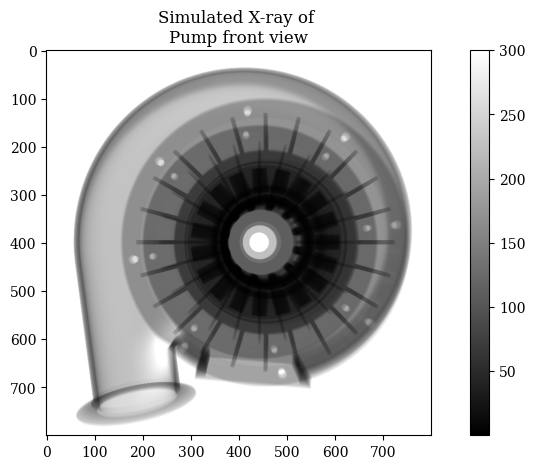

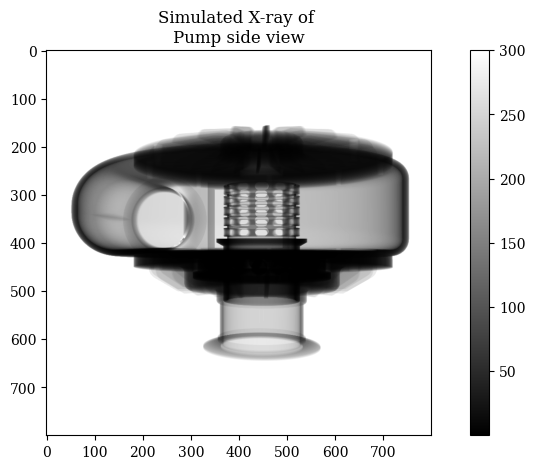

In [5]:
materials = ["Fe","Fe","Al","Al","Al","Fe"]
for i,name in enumerate(parts_list):
     gvxr.setElement(name, materials[i])

xray_image_front = np.array(gvxr.computeXRayImage()).astype(np.single)

# Restore the transformation matrix
gvxr.setNodeTransformationMatrix("root", transformation_matrix_backbup1)

gvxr.moveToCentre()
gvxr.translateNode("root", 0.0, 0.0, -4.0, "cm")
gvxr.rotateNode("root", 90, 1, 0, 0)

xray_image_side = np.array(gvxr.computeXRayImage()).astype(np.single)

gvxr.displayScene()

plt.figure(figsize=(10, 5))
plt.title("Simulated X-ray of \nPump front view")
plt.imshow(xray_image_front, cmap="gray")
plt.colorbar(orientation='vertical');

plt.figure(figsize=(10, 5))
plt.title("Simulated X-ray of \nPump side view")
plt.imshow(xray_image_side, cmap="gray")
plt.colorbar(orientation='vertical');
#plt.margins(0,0)

## Alloys and Mixtures

Now obviously the world is a complex place and many materials are made from mixtures of different elements. To define these in GVXR we will use a different function `gvxr.setMixture(ID,Elements,Amounts)`. Here ID is, once again a label for the model, elements is a list of atomic number for all the elements in the mixture (note: names and symbols don't currently work) and amounts are the relative amounts of each element (out of 100%). You will also need to specify the density of the mixture using `gvvxr.setDensity(ID,density,units)` in this case density is a number and units is a string that denote the units used (in this case the only allowed values are `"g/cm3"` or `"g.cm-3"`).

---
## Task:
The next task is to set any one part of your choice from the turbo-pump model to be made from stainless steel and plot both the origional and new X-ray images side by side.

In this case we will use US SAE standard 305 stainless steel which according to [World Materail](https://www.theworldmaterial.com/stainless-steel-chemical-composition/) has a density of 8 g/cm^-3 and consists of:
|Element|relative percentage|
|---|---|
|Carbon|0.12|
|Manganese|2.00|
|Si|1.00|
|Chromium|19.0|
|Ni|11.0|
|Iron|66.85|

Note: unless you have a particularly good monitor small differences in greyscale can be somewhat difficult to see. So to show the difference more clearly you may find it easier using either a different colormap (matplotlib has a number you can choose [from](https://matplotlib.org/stable/tutorials/colors/colormaps.html)) or you can use the `compareWithGroundTruth()` function. 

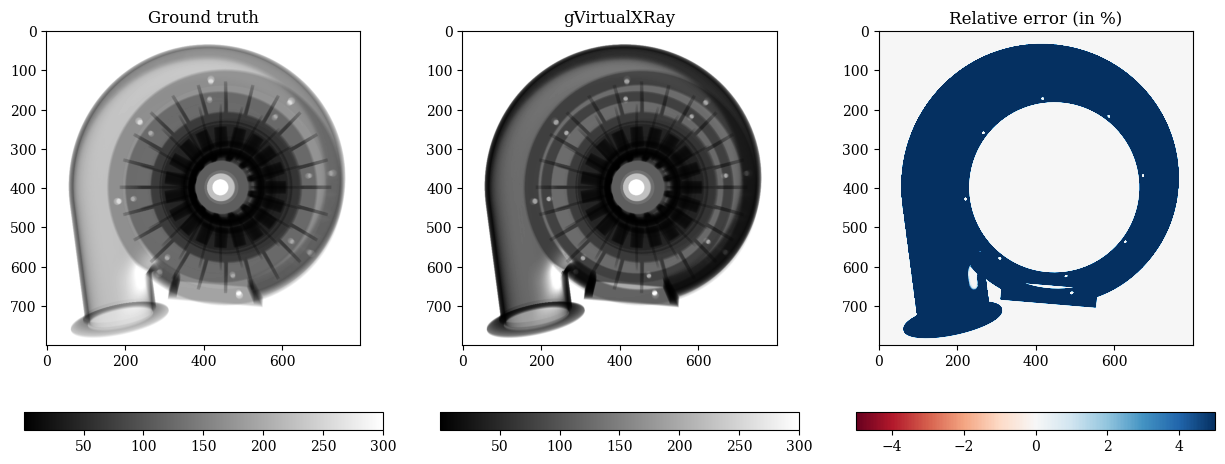

In [6]:
elements = [6,25,14,24,28,26]
ammounts = [0.12,2.00,1.00,19.0,11.0,66.85]

# reset view to front as this looks better in my opinion
# restore the transformation matrix
gvxr.setNodeTransformationMatrix("root", transformation_matrix_backbup2)

xray_image_1 = np.array(gvxr.computeXRayImage()).astype(np.single)

# set only housing to be made from stainless
gvxr.setMixture(parts_list[4],elements,ammounts)
gvxr.setDensity(parts_list[4], 8.0, "g/cm3")

xray_image_2 = np.array(gvxr.computeXRayImage()).astype(np.single)

compareWithGroundTruth(xray_image_1, xray_image_2, figsize=(12.5, 5))


## Working with compounds

Working with compounds is much the same as mixtures, the main difference being you use a chemical formulae to define the relative amounts of each element eg. carbon dioxide: "CO2" as opposed to exact percentages. GVXR allows this by using the `gvxr.setCompound(ID, Formulae)` where Formulae is a string representing the chemical formula of the compound you wish to use. For example water would be "H2O", methane would be "CH4", Silicon carbide would be "SiC" ect ...

Note: when using this we still need to explicitly set the density using `gvxr.setDensity()`.

---
## Task: 

For the final task set a part of the pump of your choice to be made from Titanium dioxide (the formulae for which is TiO2) which for the record has a density of 4.7 g/cm^-3 [^2].

[^2]:  Haynes, W.M. (ed.). CRC Handbook of Chemistry and Physics. 94th Edition. CRC Press LLC, Boca Raton: FL 2013-2014, p. 4-96

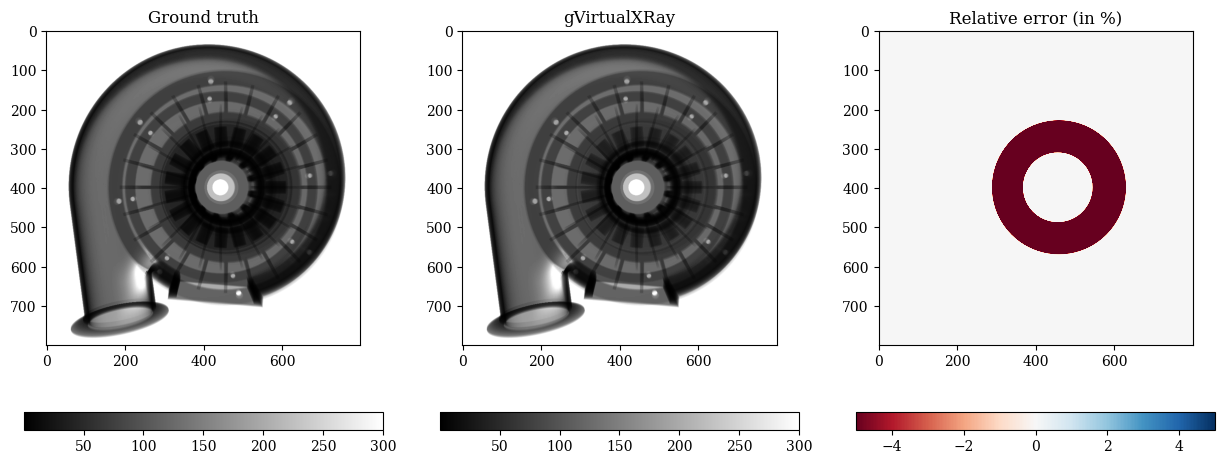

In [7]:
# set central bearing to be made from TiO2
gvxr.setCompound(parts_list[5],"TiO2")
gvxr.setDensity(parts_list[5], 4.7, "g/cm3")

xray_image_3 = np.array(gvxr.computeXRayImage()).astype(np.single)

compareWithGroundTruth(xray_image_2, xray_image_3, figsize=(12.5, 5))

In [8]:
gvxr.terminate()

Wed Oct 12 08:28:34 2022 ---- Destroy all the windows
Wed Oct 12 08:28:34 2022 ---- Destroy window 0(0x5567b76548c0)
